# Classification Approach

## 1 Imports and Config

### 1.1 Imports

In [1]:
import os
import allel
import pickle

import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

### 1.2 Config

In [2]:
HOME = "cs4220/ass1"
os.listdir()

['syn2',
 'syn1.zip',
 'syn5',
 'syn1',
 'real3',
 'Notebook_1.ipynb',
 'data.pkl',
 'test',
 'real1.zip',
 'real2_part2.zip',
 'real2_part1.zip',
 'syn4',
 'test.zip',
 'syn3',
 'real1',
 '.ipynb_checkpoints',
 'syn4.zip',
 'syn3.zip',
 'syn2.zip',
 'Classification.ipynb',
 'syn5.zip',
 'real2']

In [3]:
datasets = ['real1', 'real2', 'real3', 'syn1', 'syn2', 'syn3', 'syn4', 'syn5']
methods = ['freebayes', 'mutect2', 'varscan', 'vardict']
dfs = {}

## 2. Get data from files

Skip 2.1 and 2.2 if you already have the pickle file.

### 2.1 Load data to dataframe

In [8]:
for dataset in datasets:
    temp_dfs = {}
    for method in methods:
        temp_df = allel.vcf_to_dataframe(dataset+'/'+dataset+'-'+method+'.vcf.gz')
        temp_dfs[method] = temp_df
        print(f'Read {method} from {dataset}')
    merged = temp_dfs['freebayes'][['CHROM', 'POS', 'FILTER_PASS']].merge(temp_dfs['mutect2'][['CHROM', 'POS', 'FILTER_PASS']], 
                                                   how='outer', on=['CHROM', 'POS'], 
                                                   suffixes=['_freebayes', '_mutect2']).merge(temp_dfs['vardict'][['CHROM', 'POS', 'FILTER_PASS']], 
                                                   how='outer', on=['CHROM', 'POS']).merge(temp_dfs['varscan'][['CHROM', 'POS', 'FILTER_PASS']], 
                                                   how='outer', on=['CHROM', 'POS'], suffixes=['_vardict', '_varscan'])
    combined_df = None
    if(dataset == 'real3'):
        combined_df = merged
    else:
        truth_df = pd.read_csv(dataset+'/'+dataset+'_truth.bed', delimiter='\t', header=0, names=['CHROM', 'START_POS', 'END_POS'])
        if(dataset == 'real2'):
            combined_df = merged.merge(truth_df[['CHROM', 'START_POS']].astype({'CHROM': 'object'}), how='outer', left_on=['CHROM', 'POS'], right_on=['CHROM', 'START_POS'])
        else:
            combined_df = merged.merge(truth_df[['CHROM', 'START_POS']], how='outer', left_on=['CHROM', 'POS'], right_on=['CHROM', 'START_POS'])
        combined_df['y'] = combined_df['START_POS'].notna()
        combined_df['y_true'] = combined_df['y'].astype(int) 
    combined_df['FILTER_PASS_freebayes'] = combined_df['FILTER_PASS_freebayes'].fillna(-1).astype(int)
    combined_df['FILTER_PASS_mutect2'] = combined_df['FILTER_PASS_mutect2'].fillna(-1).astype(int)
    combined_df['FILTER_PASS_vardict'] = combined_df['FILTER_PASS_vardict'].fillna(-1).astype(int)
    combined_df['FILTER_PASS_varscan'] = combined_df['FILTER_PASS_varscan'].fillna(-1).astype(int)
    dfs[dataset] = combined_df

Read freebayes from real1
Read mutect2 from real1
Read varscan from real1
Read vardict from real1
Read freebayes from real2
Read mutect2 from real2
Read varscan from real2
Read vardict from real2
Read freebayes from real3
Read mutect2 from real3
Read varscan from real3
Read vardict from real3
Read freebayes from syn1
Read mutect2 from syn1
Read varscan from syn1
Read vardict from syn1
Read freebayes from syn2
Read mutect2 from syn2
Read varscan from syn2
Read vardict from syn2
Read freebayes from syn3
Read mutect2 from syn3
Read varscan from syn3
Read vardict from syn3
Read freebayes from syn4
Read mutect2 from syn4
Read varscan from syn4
Read vardict from syn4
Read freebayes from syn5
Read mutect2 from syn5
Read varscan from syn5
Read vardict from syn5


### 2.2 Save to pickle

In [9]:
with open('data.pkl', 'wb') as fp:
    pickle.dump(dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)

### 2.3 Load from pickle

In [4]:
p_data = None
with open('data.pkl', 'rb') as fp:
    p_data = pickle.load(fp)

In [5]:
p_data['real1'].head()

,CHROM,POS,FILTER_PASS_freebayes,FILTER_PASS_mutect2,FILTER_PASS_vardict,FILTER_PASS_varscan,START_POS,y,y_true
0,1,10177.0,0,-1,-1,0,NaN,False,0
1,1,10583.0,0,-1,0,0,NaN,False,0
2,1,12783.0,0,-1,0,0,NaN,False,0
3,1,13116.0,0,-1,0,-1,NaN,False,0
4,1,13118.0,0,-1,0,-1,NaN,False,0


In [6]:
p_data.keys()

dict_keys(['real1', 'real2', 'real3', 'syn1', 'syn2', 'syn3', 'syn4', 'syn5'])

## 3. Classification 

### 3.1 Config

In [7]:
split_ratio = 0.75
seed = 42
features = ['FILTER_PASS_freebayes', 'FILTER_PASS_mutect2', 'FILTER_PASS_vardict', 'FILTER_PASS_varscan']
target = ['y_true']
train_test_sets = ['real1', 'syn1', 'syn2', 'syn3', 'syn4', 'syn5']
validation_sets = ['real2']
test_sets = ['real3']
df = p_data['real1']

### 3.2 Data preparation

In [8]:
def split_data(df):
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], train_size = split_ratio, stratify = df[target])
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    print(y_train.value_counts().to_dict())
    print(y_test.value_counts().to_dict())
    return(X_train, X_test, y_train, y_test)

In [9]:
X_train, X_test, y_train, y_test = split_data(df)

(4342672, 4)
(1447558, 4)
(4342672, 1)
(1447558, 1)
{(0,): 4341684, (1,): 988}
{(0,): 1447228, (1,): 330}


### 3.3 Classifier

In [10]:
clf = RandomForestClassifier(warm_start = True, random_state=seed)

In [11]:
results = {}
for file in train_test_sets:
    df = p_data[file]
    X_train, X_test, y_train, y_test = split_data(df)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[file] = {}
    results[file]['Precision'] = precision_score(y_test, y_pred)
    results[file]['Recall'] = recall_score(y_test, y_pred)
    results[file]['F1 Score'] = f1_score(y_test, y_pred)

(4342672, 4)
(1447558, 4)
(4342672, 1)
(1447558, 1)
{(0,): 4341684, (1,): 988}
{(0,): 1447228, (1,): 330}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


(4154334, 4)
(1384778, 4)
(4154334, 1)
(1384778, 1)
{(0,): 4151682, (1,): 2652}
{(0,): 1383894, (1,): 884}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/e/e0925482/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


(4337421, 4)
(1445807, 4)
(4337421, 1)
(1445807, 1)
{(0,): 4334173, (1,): 3248}
{(0,): 1444724, (1,): 1083}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/e/e0925482/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


(4224917, 4)
(1408306, 4)
(4224917, 1)
(1408306, 1)
{(0,): 4218991, (1,): 5926}
{(0,): 1406330, (1,): 1976}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/e/e0925482/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


(3785022, 4)
(1261675, 4)
(3785022, 1)
(1261675, 1)
{(0,): 3772787, (1,): 12235}
{(0,): 1257596, (1,): 4079}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/e/e0925482/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


(3733499, 4)
(1244500, 4)
(3733499, 1)
(1244500, 1)
{(0,): 3699463, (1,): 34036}
{(0,): 1233154, (1,): 11346}


/tmp/ipykernel_3457992/3194442641.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/e/e0925482/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:429: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [12]:
results

{'real1': {'Precision': 0.8452012383900929,
  'Recall': 0.8272727272727273,
  'F1 Score': 0.8361408882082696},
 'syn1': {'Precision': 0.9119565217391304,
  'Recall': 0.9490950226244343,
  'F1 Score': 0.9301552106430155},
 'syn2': {'Precision': 0.9668615984405458,
  'Recall': 0.9159741458910434,
  'F1 Score': 0.9407302038880986},
 'syn3': {'Precision': 0.6681240063593005,
  'Recall': 0.8507085020242915,
  'F1 Score': 0.7484416740872663},
 'syn4': {'Precision': 0.6851965601965602,
  'Recall': 0.5469477813189507,
  'F1 Score': 0.6083162917518746},
 'syn5': {'Precision': 0.8261672824991603,
  'Recall': 0.8670897232504847,
  'F1 Score': 0.8461339984518792}}

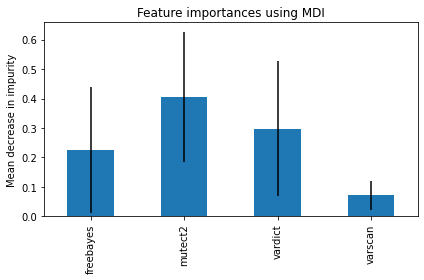

In [13]:
feature_names = [x.split('_')[2] for x in X_train.columns]
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Validation

In [14]:
val_results = {}
for file in validation_sets:
    df = p_data[file]
    X_test, y_test = df[features], df[target]
    y_pred = clf.predict(X_test)
    val_results[file] = {}
    val_results[file]['Precision'] = precision_score(y_test, y_pred)
    val_results[file]['Recall'] = recall_score(y_test, y_pred)
    val_results[file]['F1 Score'] = f1_score(y_test, y_pred)
val_results

{'real2': {'Precision': 0.4909819639278557,
  'Recall': 1.0,
  'F1 Score': 0.6586021505376344}}

## Get Predictions

In [17]:
for file in test_sets:
    df = p_data[file]
    X_test = df[features]
    y_pred = clf.predict(X_test)
    df['y_pred'] = y_pred
    res_df = df.copy()
    res_df = res_df[res_df['y_pred'] == 1]
    res_df.drop(['FILTER_PASS_freebayes', 'FILTER_PASS_mutect2', 'FILTER_PASS_vardict', 'FILTER_PASS_varscan', 'y_pred'], axis=1, inplace = True)
    res_df.columns = ['CHROM', 'START_POS']
    res_df['END_POS'] = res_df['START_POS']
    res_df.to_csv(file+'_test.bed', sep='\t')